<h1>Decision Tree</h1>

## Loading Data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re

import pickle
from tqdm import tqdm
import os

import chart_studio.plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [2]:
data = pd.read_csv('preprocessed_data.csv')

In [3]:
y=data['project_is_approved']
X=data.drop(['project_is_approved'],axis=1)
X.head()

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   
3           ga            mrs          grades_prek_2   
4           wa            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects   clean_categories  \
0                                            53       math_science   
1                                             4       specialneeds   
2                                            10  literacy_language   
3                                             2    appliedlearning   
4                                             2  literacy_language   

                  clean_subcategories  \
0  appliedsciences health_lifescience   
1                        specialneeds   
2                            literacy   
3                    earlydevelopment   
4                            literacy   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00  
3  i recently read article giving students choice...  481.04  
4  my students crave challenge eat obstacles brea...   17.74

<h2>Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
  
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print("shape of train and test after split")
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

shape of train and test after split
(76473, 8) (76473,)
(32775, 8) (32775,)


<h2>Make Data Model Ready: encoding essay</h2>

## encoding essay TFIDF

In [5]:
#TFIDF ON Preproccesed Essay

vectorizer_essaytfidf = TfidfVectorizer(min_df=10)
vectorizer_essaytfidf.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_essaytfidf.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_essaytfidf.transform(X_test['essay'].values)

print("After Tfidf vectorization of Essay")
print(X_train_essay_tfidf.shape, y_train.shape)  #shapes of Train ,Test after encoding
print(X_test_essay_tfidf.shape, y_test.shape)

After Tfidf vectorization of Essay
(76473, 14476) (76473,)
(32775, 14476) (32775,)


## Using Pretrained Models: TFIDF weighted W2V

In [6]:

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [7]:

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [8]:
# average Word2Vec
# compute average word2vec for each review.
def tfidf_weighted_w2v(preprocessed_essay):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_essay): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    return tfidf_w2v_vectors

In [9]:
X_train_tfidf_weighted_w2v=tfidf_weighted_w2v(X_train['essay'].values)
X_test_tfidf_weighted_w2v=tfidf_weighted_w2v(X_test['essay'].values)

  1%|▌                                                                            | 253/32775 [00:00<01:05, 493.15it/s]

76473
300


100%|███████████████████████████████████████████████████████████████████████████| 32775/32775 [01:14<00:00, 441.06it/s]

32775
300


<h2>Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>encoding categorical features: School State</h3>

In [10]:
vectorizer_state= CountVectorizer(binary=True)

X_train_state = vectorizer_state.fit_transform(X_train['school_state'].values)
X_test_state = vectorizer_state.fit_transform(X_test['school_state'].values)

print("Shape of matrix after one hot encoding ")
print(X_train_state.shape,y_train.shape)
print(X_test_state.shape,y_test.shape)

Shape of matrix after one hot encoding 
(76473, 51) (76473,)
(32775, 51) (32775,)


<h3>encoding categorical features: Teacher Prefix</h3>

In [11]:
vectorizer_prefix= CountVectorizer(binary=True)

X_train_prefix = vectorizer_prefix.fit_transform(X_train['teacher_prefix'].values)
X_test_prefix = vectorizer_prefix.fit_transform(X_test['teacher_prefix'].values)

print("Shape of matrix after one hot encoding ")
print(X_train_prefix.shape,y_train.shape)
print(X_test_prefix.shape,y_test.shape)

Shape of matrix after one hot encoding 
(76473, 5) (76473,)
(32775, 5) (32775,)


<h3>encoding categorical features: Project Grade Category</h3>

In [12]:
vectorizer_grade= CountVectorizer(binary=True)

X_train_grade = vectorizer_grade.fit_transform(X_train['project_grade_category'].values)
X_test_grade= vectorizer_grade.fit_transform(X_test['project_grade_category'].values)

print("Shape of matrix after one hot encoding ")
print(X_train_grade.shape,y_train.shape)
print(X_test_grade.shape,y_test.shape)

Shape of matrix after one hot encoding 
(76473, 4) (76473,)
(32775, 4) (32775,)


<h3>encoding categorical features: Clean Categories</h3>

In [13]:
vectorizer_categories= CountVectorizer(binary=True)

X_train_categories = vectorizer_categories.fit_transform(X_train['clean_categories'].values)
X_test_categories= vectorizer_categories.fit_transform(X_test['clean_categories'].values)

print("Shape of matrix after one hot encoding ")
print(X_train_categories.shape,y_train.shape)
print(X_test_categories.shape,y_test.shape)

Shape of matrix after one hot encoding 
(76473, 9) (76473,)
(32775, 9) (32775,)


<h3>encoding categorical features: Clean SubCategories</h3>

In [14]:
vectorizer_subcategories= CountVectorizer(binary=True)

X_train_subcategories = vectorizer_subcategories.fit_transform(X_train['clean_subcategories'].values)
X_test_subcategories = vectorizer_subcategories.fit_transform(X_test['clean_subcategories'].values)

print("Shape of matrix after one hot encoding ")
print(X_train_subcategories.shape,y_train.shape)
print(X_test_subcategories.shape,y_test.shape)

Shape of matrix after one hot encoding 
(76473, 30) (76473,)
(32775, 30) (32775,)


<h3>encoding Numerical features: teacher_number_of_previously_posted_projects</h3>

In [15]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj=(normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))).reshape(-1,1)
X_test_prev_proj=(normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))).reshape(-1,1)

print("shape of matrix")
print(X_train_prev_proj.shape, y_train.shape)
print(X_test_prev_proj.shape, y_test.shape)

shape of matrix
(76473, 1) (76473,)
(32775, 1) (32775,)


<h3>encoding Numerical features: Price </h3>

In [16]:

normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price= (normalizer.transform(X_train['price'].values.reshape(1,-1))).reshape(-1,1)
X_test_price=(normalizer.transform(X_test['price'].values.reshape(1,-1))).reshape(-1,1)

print("Shape of price matrix")
print(X_train_price.shape, y_train.shape)
print(X_test_price.shape, y_test.shape)

Shape of price matrix
(76473, 1) (76473,)
(32775, 1) (32775,)


## Concatinating all the features (essay-TFIDF)

In [17]:
#concatinating all features- essay(tfidf)+Categorical+ Numerical Features using hstack

from scipy.sparse import hstack

X_train_tfidf=hstack((X_train_essay_tfidf,X_train_state,X_train_prefix,X_train_grade,X_train_categories,X_train_subcategories,X_train_price,X_train_prev_proj)).tocsr()
X_test_tfidf=hstack((X_test_essay_tfidf,X_test_state,X_test_prefix,X_test_grade,X_test_categories,X_test_subcategories,X_test_price,X_test_prev_proj)).tocsr()

print("Final Data matrix")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

Final Data matrix
(76473, 14577) (76473,)
(32775, 14577) (32775,)


## Concatinating all the features (essay-TFIDF_Weighted_W2V)

In [18]:
#concatinating all features- essay(tfidf_weighted_w2v)+Categorical+ Numerical Features using hstack

X_train_tfidfw2v=hstack((X_train_tfidf_weighted_w2v,X_train_state,X_train_prefix,X_train_grade,X_train_categories,X_train_subcategories,X_train_price,X_train_prev_proj))
X_test_tfidfw2v=hstack((X_test_tfidf_weighted_w2v,X_test_state,X_test_prefix,X_test_grade,X_test_categories,X_test_subcategories,X_test_price,X_test_prev_proj))

print("Final Data matrix")
print(X_train_tfidfw2v.shape, y_train.shape)
print(X_test_tfidfw2v.shape, y_test.shape)

Final Data matrix
(76473, 401) (76473,)
(32775, 401) (32775,)


<h1>Appling  Decision Tree on different kind of featurization</h2>

# Applying Decision Tree Set 1 Essay-TFIDF

## Hyper Parameter Tuning

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

dtclf=DecisionTreeClassifier(class_weight='balanced')

parameters={'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
clf=GridSearchCV(dtclf,parameters,cv=3,scoring='roc_auc',return_train_score='True')
clf.fit(X_train_tfidf,y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth','param_min_samples_split'])

train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
max_depth= results['param_max_depth']
min_samples_split= results['param_min_samples_split']

results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.098887      0.124138         0.086103        0.000493   
1       0.990684      0.080930         0.086104        0.000470   
2       0.930178      0.002351         0.086793        0.001629   
3       1.022265      0.068000         0.107381        0.005778   
4       4.323438      0.162184         0.087765        0.000815   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.543328   
1   {'max_depth': 1, 'min_samples_split': 10}           0.543328   
2  {'max_depth': 1, 'min_samples_split': 100}           0.543328   
3  {'max_depth': 1, 'min_samples_split': 500}           0.543328   
4    {'max_depth': 5, 'min_samples_split': 5}           0.627402   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.541953           0.550895         0.545392        0.003931   
1           0.541953           0.550895         0.545392        0.003931   
2           0.541953           0.550895         0.545392        0.003931   
3           0.541953           0.550895         0.545392        0.003931   
4           0.625535           0.626332         0.626423        0.000765   

   rank_test_score  split0_train_score  split1_train_score  \
0               13            0.543324            0.551316   
1               13            0.543324            0.551316   
2               13            0.543324            0.551316   
3               13            0.543324            0.551316   
4                6            0.647106            0.653015   

   split2_train_score  mean_train_score  std_train_score  
0            0.546895          0.547178         0.003269  
1            0.546895          0.547178         0.003269  
2            0.546895          0.547178         0.003269  
3            0.546895          0.547178         0.003269  
4            0.639338          0.646486         0.005601

In [20]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 500}

In [21]:
best_maxdepth=clf.best_params_['max_depth']
best_minsamplessplit=clf.best_params_['min_samples_split']
print(best_maxdepth,best_minsamplessplit)

10 500


## Representation of Results

In [22]:
# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=min_samples_split,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=min_samples_split,y=max_depth,z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

## Testing Performance of the Model with Best Hyper Parameters

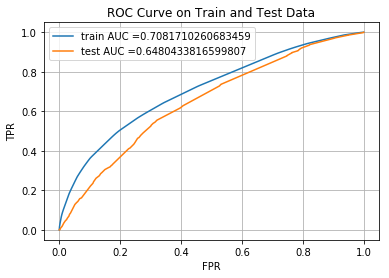

In [23]:
from sklearn.metrics import roc_curve, auc

classfier=DecisionTreeClassifier(max_depth=best_maxdepth,min_samples_split=best_minsamplessplit,class_weight='balanced')
classfier.fit(X_train_tfidf,y_train)

y_train_pred=classfier.predict_proba(X_train_tfidf)[:,1]
y_test_pred=classfier.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, train_thresolds = roc_curve(y_train,y_train_pred)
test_fpr, test_tpr, test_thresolds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr))) #plotting ROC Curves for train and test datasets
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve on Train and Test Data")
plt.grid()
plt.show()

In [24]:
print("AUC score on Train data is ")
print(auc(train_fpr, train_tpr))
print("AUC score on Test data is ")
print(auc(test_fpr, test_tpr))

AUC score on Train data is 
0.7081710260683459
AUC score on Test data is 
0.6480433816599807


In [25]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_thresold(thresold, fpr, tpr):
    t = thresold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr) is ", max(tpr*(1-fpr)), "for thresold", np.round(t,3))
    return t

def predict_with_best_t(proba,thresold):
    predictions = []
    for i in proba:
        if i>=thresold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [26]:
from sklearn.metrics import confusion_matrix
best_t = find_best_thresold(train_thresolds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) is  0.4234925664701732 for thresold 0.476
Train confusion matrix
[[ 8286  3293]
 [26490 38404]]
Test confusion matrix
[[ 3371  1592]
 [12374 15438]]


## Word Cloud

In [27]:
X_testessay=X_test['essay'].values
predictions=predict_with_best_t(y_test_pred,best_t)
y_actual=y_test.values
essay_words=' '
index=[]
for i in range(len(y_test)):
    if predictions[i]==1 and y_actual[i]==0: #false positive
        index.append(i)
        tokens=X_testessay[i].split() ## split the each false positive essayword
        essay_words+=" ".join(tokens)+" "

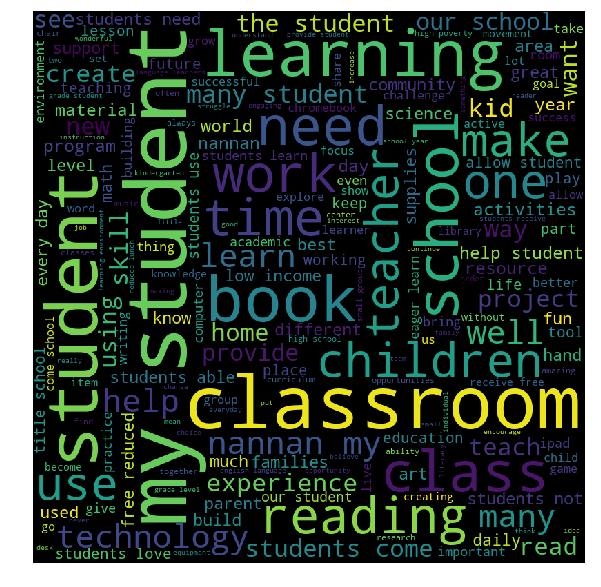

In [28]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

wordcloud=WordCloud(width = 800, height = 800,stopwords=stopwords,min_font_size = 10).generate(essay_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Box Plot

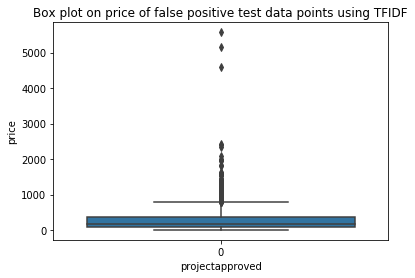

In [29]:
price=X_test['price'].values
fp_prices=np.take(price,index)
sns.boxplot(data=fp_prices)
plt.xlabel("projectapproved")
plt.ylabel("price")
plt.title("Box plot on price of false positive test data points using TFIDF")
plt.show()

## PDF

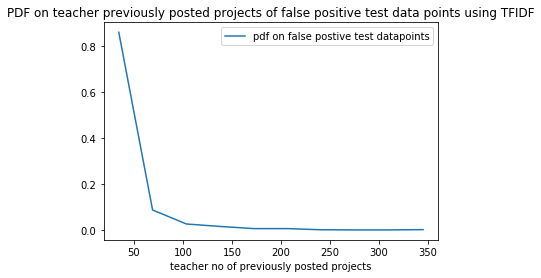

In [30]:
prevprojects=X_test['teacher_number_of_previously_posted_projects'].values
fp_prevprojects=np.take(prevprojects,index)

counts,bin_edges = np.histogram(fp_prevprojects,bins=10,density=True)
pdf=counts/(sum(counts))
plt.plot(bin_edges[1:],pdf,label="pdf on false postive test datapoints")

plt.title("PDF on teacher previously posted projects of false positive test data points using TFIDF")
plt.xlabel("teacher no of previously posted projects")

plt.legend()
plt.show()

# Applying Decision Tree Set 2 Essay-TFIDF W2V

## Hyper Parameter Tuning

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

dtclf=DecisionTreeClassifier(class_weight='balanced')

parameters={'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
clf=GridSearchCV(dtclf,parameters,cv=3,scoring='roc_auc',return_train_score='True')
clf.fit(X_train_tfidfw2v,y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth','param_min_samples_split'])

train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
max_depth= results['param_max_depth']
min_samples_split= results['param_min_samples_split']

results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.153565      0.097813         0.246674        0.014778   
1       2.991999      0.049474         0.246342        0.005642   
2       3.129298      0.388402         0.258654        0.020972   
3       3.067143      0.267386         0.238018        0.001704   
4      13.536797      0.112376         0.255982        0.014042   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.543328   
1   {'max_depth': 1, 'min_samples_split': 10}           0.543328   
2  {'max_depth': 1, 'min_samples_split': 100}           0.543328   
3  {'max_depth': 1, 'min_samples_split': 500}           0.543328   
4    {'max_depth': 5, 'min_samples_split': 5}           0.623902   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.541953           0.550895         0.545392        0.003931   
1           0.541953           0.550895         0.545392        0.003931   
2           0.541953           0.550895         0.545392        0.003931   
3           0.541953           0.550895         0.545392        0.003931   
4           0.628123           0.633426         0.628484        0.003897   

   rank_test_score  split0_train_score  split1_train_score  \
0               11            0.543324            0.551316   
1               11            0.543324            0.551316   
2               11            0.543324            0.551316   
3               11            0.543324            0.551316   
4                1            0.660767            0.661864   

   split2_train_score  mean_train_score  std_train_score  
0            0.546895          0.547178         0.003269  
1            0.546895          0.547178         0.003269  
2            0.546895          0.547178         0.003269  
3            0.546895          0.547178         0.003269  
4            0.657276          0.659969         0.001956

In [32]:
clf.best_params_

{'max_depth': 5, 'min_samples_split': 5}

In [33]:
best_maxdepth=clf.best_params_['max_depth']
best_minsamplessplit=clf.best_params_['min_samples_split']
print(best_maxdepth,best_minsamplessplit)

5 5


## Representation of Results

In [34]:
# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=min_samples_split,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=min_samples_split,y=max_depth,z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

## Testing Performance of the Model with Best Hyper Parameters

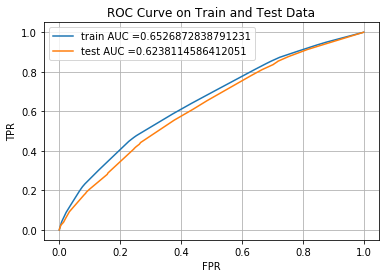

In [35]:
from sklearn.metrics import roc_curve, auc

classfier=DecisionTreeClassifier(max_depth=best_maxdepth,min_samples_split=best_minsamplessplit,class_weight='balanced')
classfier.fit(X_train_tfidfw2v,y_train)

#y_train_pred=batch_predict(classfier,X_train_tfidf)    
#y_test_pred=batch_predict(classfier,X_test_tfidf)
y_train_pred=classfier.predict_proba(X_train_tfidfw2v)[:,1]
y_test_pred=classfier.predict_proba(X_test_tfidfw2v)[:,1]

train_fpr, train_tpr, train_thresolds = roc_curve(y_train,y_train_pred)
test_fpr, test_tpr, test_thresolds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr))) #plotting ROC Curves for train and test datasets
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve on Train and Test Data")
plt.grid()
plt.show()

In [36]:
print("AUC score on Train data is ")
print(auc(train_fpr, train_tpr))
print("AUC score on Test data is ")
print(auc(test_fpr, test_tpr))

AUC score on Train data is 
0.6526872838791231
AUC score on Test data is 
0.6238114586412051


In [37]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_thresold(thresold, fpr, tpr):
    t = thresold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr) is ", max(tpr*(1-fpr)), "for thresold", np.round(t,3))
    return t

def predict_with_best_t(proba,thresold):
    predictions = []
    for i in proba:
        if i>=thresold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [38]:
from sklearn.metrics import confusion_matrix
best_t = find_best_thresold(train_thresolds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) is  0.36815747329133447 for thresold 0.479
Train confusion matrix
[[ 7269  4310]
 [26837 38057]]
Test confusion matrix
[[ 3084  1879]
 [12340 15472]]


## Word Cloud

In [39]:
X_testessay=X_test['essay'].values
predictions=predict_with_best_t(y_test_pred,best_t)
y_actual=y_test.values
essay_words=' '
index=[]
for i in range(len(y_test)):
    if predictions[i]==1 and y_actual[i]==0: #false positive
        index.append(i)
        tokens=X_testessay[i].split() ## split the each false positive essayword
        essay_words+=" ".join(tokens)+" "

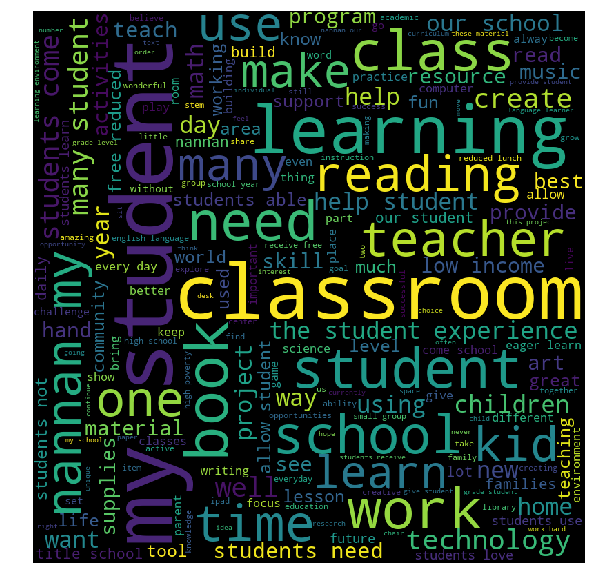

In [40]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

wordcloud=WordCloud(width = 800, height = 800,stopwords=stopwords,min_font_size = 10).generate(essay_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Box Plot

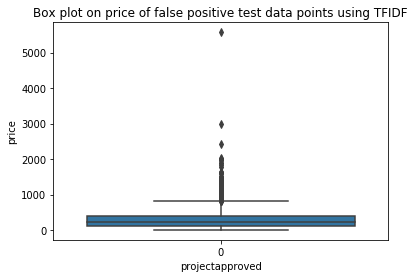

In [41]:
price=X_test['price'].values
fp_prices=np.take(price,index)
sns.boxplot(data=fp_prices)
plt.xlabel("projectapproved")
plt.ylabel("price")
plt.title("Box plot on price of false positive test data points using TFIDF")
plt.show()

## PDF

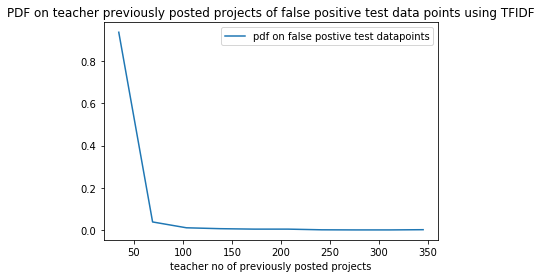

In [42]:
prevprojects=X_test['teacher_number_of_previously_posted_projects'].values
fp_prevprojects=np.take(prevprojects,index)

counts,bin_edges = np.histogram(fp_prevprojects,bins=10,density=True)
pdf=counts/(sum(counts))
plt.plot(bin_edges[1:],pdf,label="pdf on false postive test datapoints")

plt.title("PDF on teacher previously posted projects of false positive test data points using TFIDF")
plt.xlabel("teacher no of previously posted projects")

plt.legend()
plt.show()

<h2>Getting top features using `feature_importances_`</h2>

In [43]:
from sklearn.tree import DecisionTreeClassifier
dtclf=DecisionTreeClassifier(class_weight='balanced')
dtclf.fit(X_train_tfidf,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [44]:
len(dtclf.feature_importances_)

14577

In [45]:
feature_imp=dtclf.feature_importances_

ind=[]
for i in range(len(feature_imp)):
    if feature_imp[i]>0:
        ind.append(i)

print(len(ind))

2547


In [46]:
X_train_fimp=X_train_tfidf[:,ind]
X_test_fimp=X_test_tfidf[:,ind]

print("shape of matrix after feature importance")
print(X_train_fimp.shape)
print(X_test_fimp.shape)

shape of matrix after feature importance
(76473, 2547)
(32775, 2547)


# Applying Decision Tree on top features

## Hyper Parameter Tuning

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

dtclf=DecisionTreeClassifier(class_weight='balanced')

parameters={'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
clf=GridSearchCV(dtclf,parameters,cv=3,scoring='roc_auc',return_train_score='True')
clf.fit(X_train_fimp,y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth','param_min_samples_split'])

train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
max_depth= results['param_max_depth']
min_samples_split= results['param_min_samples_split']

results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.773245      0.011205         0.025610    9.321660e-04   
1       0.820472      0.077819         0.025944    1.664420e-05   
2       0.762960      0.001628         0.024934    4.052337e-07   
3       0.825127      0.079469         0.025609    9.541485e-04   
4       3.439468      0.080169         0.026950    1.591800e-05   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.543328   
1   {'max_depth': 1, 'min_samples_split': 10}           0.543328   
2  {'max_depth': 1, 'min_samples_split': 100}           0.543328   
3  {'max_depth': 1, 'min_samples_split': 500}           0.543328   
4    {'max_depth': 5, 'min_samples_split': 5}           0.626387   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.541953           0.550895         0.545392        0.003931   
1           0.541953           0.550895         0.545392        0.003931   
2           0.541953           0.550895         0.545392        0.003931   
3           0.541953           0.550895         0.545392        0.003931   
4           0.625112           0.626631         0.626043        0.000666   

   rank_test_score  split0_train_score  split1_train_score  \
0               13            0.543324            0.551316   
1               13            0.543324            0.551316   
2               13            0.543324            0.551316   
3               13            0.543324            0.551316   
4                6            0.647073            0.652929   

   split2_train_score  mean_train_score  std_train_score  
0            0.546895          0.547178         0.003269  
1            0.546895          0.547178         0.003269  
2            0.546895          0.547178         0.003269  
3            0.546895          0.547178         0.003269  
4            0.639338          0.646446         0.005566

In [48]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 500}

In [49]:
best_maxdepth=clf.best_params_['max_depth']
best_minsamplessplit=clf.best_params_['min_samples_split']
print(best_maxdepth,best_minsamplessplit)

10 500


## Representation of Results

In [50]:
# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=min_samples_split,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=min_samples_split,y=max_depth,z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

## Testing Performance of the Model with Best Hyper Parameters

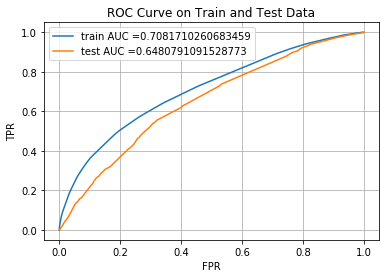

In [51]:
from sklearn.metrics import roc_curve, auc

classfier=DecisionTreeClassifier(max_depth=best_maxdepth,min_samples_split=best_minsamplessplit,class_weight='balanced')
classfier.fit(X_train_fimp,y_train)

y_train_pred=classfier.predict_proba(X_train_fimp)[:,1]
y_test_pred=classfier.predict_proba(X_test_fimp)[:,1]

train_fpr, train_tpr, train_thresolds = roc_curve(y_train,y_train_pred)
test_fpr, test_tpr, test_thresolds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr))) #plotting ROC Curves for train and test datasets
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve on Train and Test Data")
plt.grid()
plt.show()

In [52]:
print("AUC score on Train data is ")
print(auc(train_fpr, train_tpr))
print("AUC score on Test data is ")
print(auc(test_fpr, test_tpr))

AUC score on Train data is 
0.7081710260683459
AUC score on Test data is 
0.6480791091528773


In [53]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_thresold(thresold, fpr, tpr):
    t = thresold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr) is ", max(tpr*(1-fpr)), "for thresold", np.round(t,3))
    return t

def predict_with_best_t(proba,thresold):
    predictions = []
    for i in proba:
        if i>=thresold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [54]:
from sklearn.metrics import confusion_matrix
best_t = find_best_thresold(train_thresolds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) is  0.4234925664701732 for thresold 0.476
Train confusion matrix
[[ 8286  3293]
 [26490 38404]]
Test confusion matrix
[[ 3371  1592]
 [12373 15439]]


## Word Cloud

In [55]:
X_testessay=X_test['essay'].values
predictions=predict_with_best_t(y_test_pred,best_t)
y_actual=y_test.values
essay_words=' '
index=[]
for i in range(len(y_test)):
    if predictions[i]==1 and y_actual[i]==0: #false positive
        index.append(i)
        tokens=X_testessay[i].split() ## split the each false positive essayword
        essay_words+=" ".join(tokens)+" "

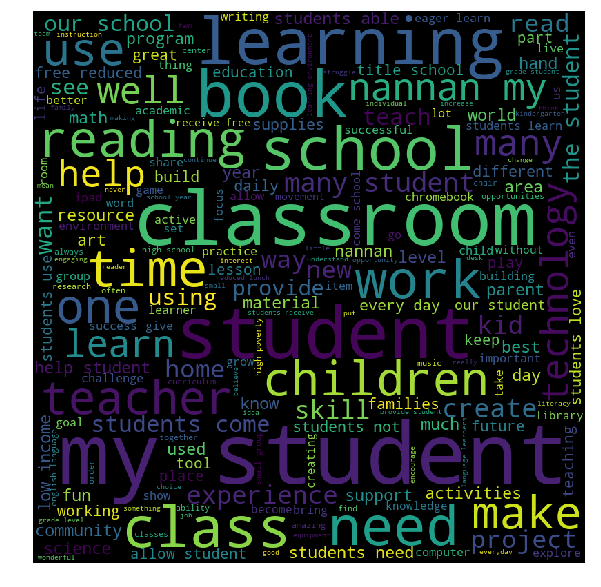

In [56]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

wordcloud=WordCloud(width = 800, height = 800,stopwords=stopwords,min_font_size = 10).generate(essay_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Box Plot

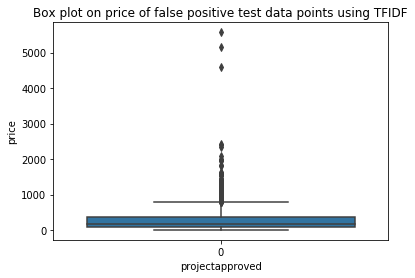

In [57]:
price=X_test['price'].values
fp_prices=np.take(price,index)
sns.boxplot(data=fp_prices)
plt.xlabel("projectapproved")
plt.ylabel("price")
plt.title("Box plot on price of false positive test data points using TFIDF")
plt.show()

## PDF

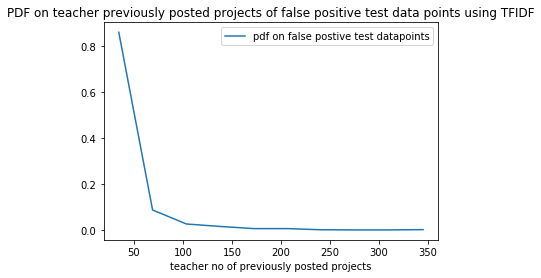

In [58]:
prevprojects=X_test['teacher_number_of_previously_posted_projects'].values
fp_prevprojects=np.take(prevprojects,index)

counts,bin_edges = np.histogram(fp_prevprojects,bins=10,density=True)
pdf=counts/(sum(counts))
plt.plot(bin_edges[1:],pdf,label="pdf on false postive test datapoints")

plt.title("PDF on teacher previously posted projects of false positive test data points using TFIDF")
plt.xlabel("teacher no of previously posted projects")

plt.legend()
plt.show()

<h1>Summary</h1>

In [59]:
from prettytable import PrettyTable
t = PrettyTable(['Vectorizer', 'Model','Hyper Parameter','AUC'])
t.add_row(['TFIDF', 'Decision Tree Classfier','max_depth:10,min_samples_split:500',0.6480])
t.add_row(['TFIDF W2V','Decision Tree Classfier','max_depth:5,min_samples_split:5',0.6238])
t.add_row(['TFIDF top_features','Decision Tree Classfier','max_depth:10,min_samples_split:500',0.6480])
print(t)

+--------------------+-------------------------+------------------------------------+--------+
|     Vectorizer     |          Model          |          Hyper Parameter           |  AUC   |
+--------------------+-------------------------+------------------------------------+--------+
|       TFIDF        | Decision Tree Classfier | max_depth:10,min_samples_split:500 | 0.648  |
|     TFIDF W2V      | Decision Tree Classfier |  max_depth:5,min_samples_split:5   | 0.6238 |
| TFIDF top_features | Decision Tree Classfier | max_depth:10,min_samples_split:500 | 0.648  |
+--------------------+-------------------------+------------------------------------+--------+
